# Import Libraries

In [4]:
import os
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [ ]:
# Parameters & Paths
img_size = (299, 299)
img_shape = (img_size[0], img_size[1], 3)
batch_size = 8
epochs = 5
learning_rate = 0.001
output_name = 'InceptionV3'
data_path = r"GLAZE-evaluation\dataset\train"
model_output_path = r"D:\GLAZE-evaluation\model\\" + output_name + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S") + ".h5"

In [ ]:
# Logging
log_path = r"GLAZE-evaluation\log\\" + output_name + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)

# Dataset Prep

In [7]:
images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        full_image_path = os.path.join(subfolder_path, image_filename)
        images.append(full_image_path)
        labels.append(subfolder)
        
data = pd.DataFrame({'image': images, 'label': labels})

In [8]:
train_df, valid_test_df = train_test_split(
    data, 
    test_size=0.2, # 20% for validation/test
    stratify=data['label'], 
    random_state=123
)

valid_df, test_df = train_test_split(
    valid_test_df, 
    test_size=0.5, # Split the 20% into two 10% halves
    stratify=valid_test_df['label'], 
    random_state=123
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Total images found: {len(data)}")
print(f"Train DF size: {len(train_df)}")
print(f"Validation DF size: {len(valid_df)}")
print(f"Test DF size: {len(test_df)}")

Total images found: 400
Train DF size: 320
Validation DF size: 40
Test DF size: 40


In [9]:
data.shape

(400, 2)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    color_mode='rgb', 
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [11]:
print(len(train_df))
print(len(valid_df))
print(len(test_df))

320
40
40


# InceptionV3

In [12]:
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape
)

In [13]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [15]:
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
checkpoint = ModelCheckpoint(
    'roko_style.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

In [18]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.5621 - loss: 20.5215
Epoch 1: val_accuracy improved from None to 0.85000, saving model to roko_style.h5


40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.6062 - loss: 15.4853 - val_accuracy: 0.8500 - val_loss: 1.7207 - learning_rate: 0.0010
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.6790 - loss: 9.0167
Epoch 2: val_accuracy did not improve from 0.85000
40/40 ━━━━━━━━━━━━━━━━━━━━ 38s 948ms/step - accuracy: 0.6875 - loss: 8.1874 - val_accuracy: 0.8500 - val_loss: 2.0181 - learning_rate: 0.0010
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.7676 - loss: 4.4231
Epoch 3: val_accuracy did not improve from 0.85000
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 979ms/step - accuracy: 0.7750 - loss: 4.4030 - val_accuracy: 0.7750 - val_loss: 2.5936 - learning_rate: 0.0010
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.8607 - loss: 3.2246
Epoch 4: val_accuracy did not improve from 0.85000
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 964ms/step - accuracy: 0.8656 - loss: 2.8492 - val_accuracy: 0.8250 - val_loss: 1.0063 - learning_rate: 0.0010
Epoch 5/5
40/40 ━━━━━━━━━━

In [19]:
model.load_weights('roko_style.h5')
model.save(model_output_path)

# Evaluation

In [20]:
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f'Train Accuracy: {train_acc:.4f}')
print(f'Train Loss: {train_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Validation Loss: {val_loss:.4f}')

Train Accuracy: 0.8094
Train Loss: 2.2200
Validation Accuracy: 0.8250
Validation Loss: 0.9680


In [21]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - accuracy: 0.8000 - loss: 0.7668
Test Accuracy: 0.8000
Test Loss: 0.7668


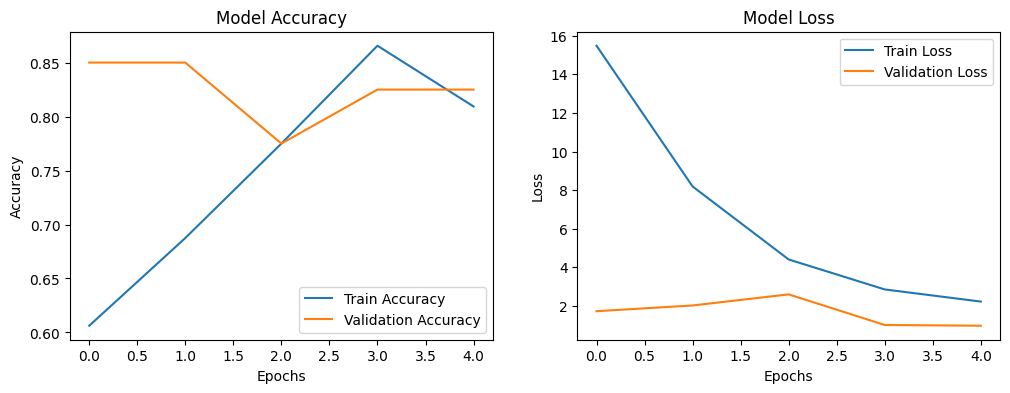

In [22]:
plt.figure(figsize=(12,4))
    
# Subplot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.round(y_pred)
y_true = test_gen.classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step


In [24]:
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

512-lora-glz       0.80      0.80      0.80        20
     512-ori       0.80      0.80      0.80        20

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



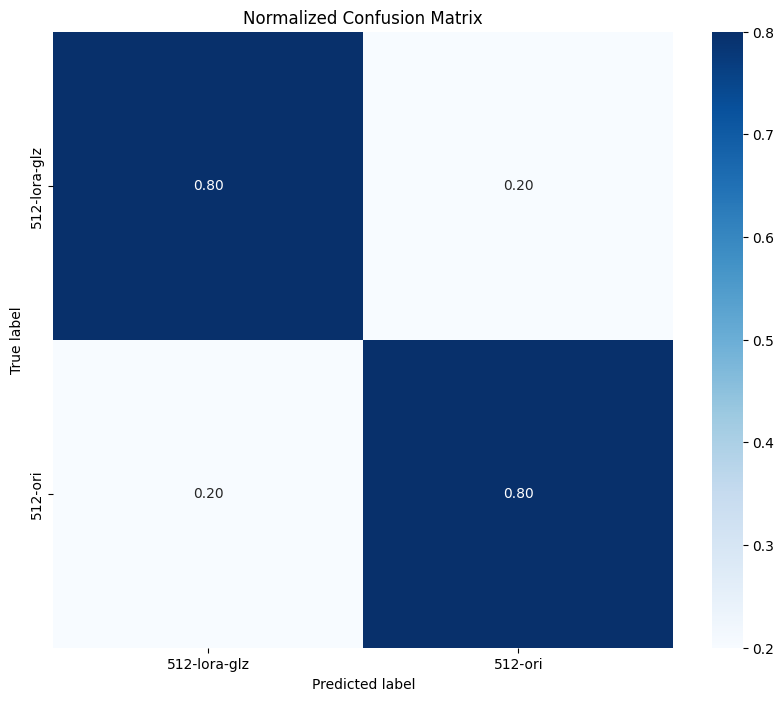

In [25]:
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()